In [5]:
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [12]:
from sklearn.naive_bayes import MultinomialNB  # 다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

###  단어사전 크기를 변경하면 실험하기

1. 분류 모델의 accuracy가 기준 이상 높게 나왔는가?  
3가지 단어 개수에 대해 8가지 머신러닝 기법을 적용하여 그중 최적의 솔루션을 도출하였다.  
2. 분류 모델의 F1 score가 기준 이상 높게 나왔는가?  
Vocabulary size에 따른 각 머신러닝 모델의 성능변화 추이를 살피고, 해당 머신러닝 알고리즘의 특성에 근거해 원인을 분석하였다.  
3. 딥러닝 모델을 활용해 성능이 비교 및 확인되었는가?  
동일한 데이터셋과 전처리 조건으로 딥러닝 모델의 성능과 비교하여 결과에 따른 원인을 분석하였다.  

### 데이터

로이터 뉴스데이터 분류 - 46개의 주제

In [41]:
# num_words로 단어사전의 크기 조절
(x_train, y_train), (x_test, y_test) = reuters.load_data(
    num_words=10000, test_split=0.2
)

훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


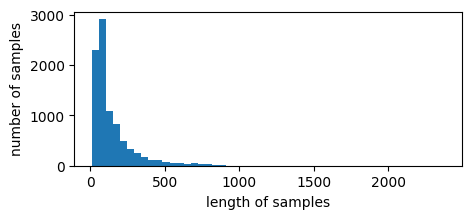

In [7]:
# 각 뉴스의 길이 분포
print("훈련용 뉴스의 최대 길이 :{}".format(max(len(l) for l in x_train)))
print("훈련용 뉴스의 평균 길이 :{}".format(sum(map(len, x_train)) / len(x_train)))
plt.figure(figsize=(5, 2))
plt.hist(
    [len(s) for s in x_train],
    bins=50,
)
plt.xlabel("length of samples")
plt.ylabel("number of samples")
plt.show()

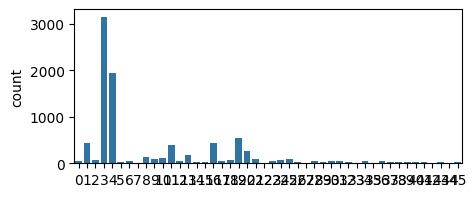

In [9]:
# 각 주제별 뉴스의 수
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(5, 2)
sns.countplot(x=y_train)
plt.show()

In [13]:
# 각 주제별 뉴스의 수, 수치화
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 클래스 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

각 클래스 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


#### 데이터 decode

데이터가 이미 벡터화되어 있는 상태로, 원본 문장으로 복원

In [15]:
# 단어 -> 수치형 사전
word_index = reuters.get_word_index(path="reuters_word_index.json")

550378/550378 [==============================] - 0s 0us/step


In [17]:
# 수치 -> 단어 사전
index_to_word = {index + 3: word for word, index in word_index.items()}
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):  # 토큰 추가
    index_to_word[index] = token

In [43]:
def decoding(data):
    decoded = []
    for i in range(len(data)):
        t = " ".join([index_to_word[index] for index in data[i]])
        decoded.append(t)
    return decoded

x_train = decoding(x_train)
x_test = decoding(x_test)

#### 벡터화

In [25]:
# TF-IDF변환을 위한 DTM
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)

In [26]:
# TF-IDF
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)

In [63]:
# 테스트 데이터 tfidf 변환
x_test_dtm = dtmvector.transform(x_test)
tfidfv_test = tfidf_transformer.transform(x_test_dtm)

## 분류 모델

In [28]:
# 혼동행렬 그리기
def graph_confusion_matrix(model, x_test, y_test):  # , classes_name):
    df_cm = pd.DataFrame(
        confusion_matrix(y_test, model.predict(x_test))
    )  # , index=classes_name, columns=classes_name)
    fig = plt.figure(figsize=(12, 12))
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(
        heatmap.yaxis.get_ticklabels(), rotation=0, ha="right", fontsize=12
    )
    heatmap.xaxis.set_ticklabels(
        heatmap.xaxis.get_ticklabels(), rotation=45, ha="right", fontsize=12
    )
    plt.ylabel("label")
    plt.xlabel("predicted value")

### 단어 사전 크기 별 비교

In [93]:
# 한번에 비교하는 함수 사용
def compare_model(word_vocab_size):
    def create_data(word_vocab_size):
        # 인코딩된 데이터를 복원
        def decoding(data):
            decoded = []
            for i in range(len(data)):
                t = " ".join([index_to_word[index] for index in data[i]])
                decoded.append(t)
            return decoded

        # 데이터 로드 및 분리
        (x_train, y_train), (x_test, y_test) = reuters.load_data(
            num_words=word_vocab_size, test_split=0.2
        )

        # 단어 -> 수치형 사전
        word_index = reuters.get_word_index(path="reuters_word_index.json")
        # 수치 -> 단어 사전
        index_to_word = {index + 3: word for word, index in word_index.items()}
        for index, token in enumerate(("<pad>", "<sos>", "<unk>")):  # 토큰 추가
            index_to_word[index] = token

        x_train = decoding(x_train)
        x_test = decoding(x_test)

        # TF-IDF변환을 위한 DTM
        dtmvector = CountVectorizer()
        x_train_dtm = dtmvector.fit_transform(x_train)

        # TF-IDF
        tfidf_transformer = TfidfTransformer()
        tfidfv = tfidf_transformer.fit_transform(x_train_dtm)

        # 테스트 데이터 tfidf 변환
        x_test_dtm = dtmvector.transform(x_test)
        tfidfv_test = tfidf_transformer.transform(x_test_dtm)

        return tfidfv, y_train, tfidfv_test, y_test

    # 모델을 가지고 성능을 확인
    def predict_model(model, tfidfv, y_train, tfidfv_test, y_test):
        model.fit(tfidfv, y_train)
        predicted = model.predict(tfidfv_test)
        print(str(model))
        acc = accuracy_score(y_test, predicted)
        print("정확도:", acc)
        # 정밀도, 재현율, f1스코어 확인
        # print(classification_report(y_test, model.predict(tfidfv_test), zero_division=0))
        # 클래스가 많고 불균형이 있으면 average="weighted"를 사용
        f1 = f1_score(y_test, predicted, average="weighted")
        print("f1 score : ", f1)

        return acc, f1

    # 주어진 단어사전 크기로 데이터 생성
    tfidfv, y_train, tfidfv_test, y_test = create_data(word_vocab_size)

    # lms에서의 파라미터를 그대로 사용
    models = [
        MultinomialNB(),
        ComplementNB(),
        LogisticRegression(C=10000, penalty="l2", max_iter=3000),
        LinearSVC(C=1000, penalty="l1", max_iter=3000, dual=False),
        DecisionTreeClassifier(max_depth=10, random_state=0),
        RandomForestClassifier(5, random_state=0),
        GradientBoostingClassifier(random_state=0),
        VotingClassifier(
            [
                (
                    "LogisticRegression",
                    LogisticRegression(C=10000, penalty="l2", max_iter=3000),
                ),
                ("ComplementNB", ComplementNB()),
                (
                    "GradientBoostingClassifier",
                    GradientBoostingClassifier(random_state=0),
                ),
            ],
            voting="soft",
        ),
    ]

    accs = []
    f1s = []

    # 각 모델별 성능 측정
    for m in models:
        acc, f1 = predict_model(m, tfidfv, y_train, tfidfv_test, y_test)
        accs.append(acc)
        f1s.append(f1)
        print("\n")

    print("평균 정확도 : ", np.mean(accs))
    print("평균 f1 score : ", np.mean(f1s))

    return accs, f1s

가이드대로 무제한과 5천개 모델 비교  
무제한의 경우 30979개

In [8]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

In [68]:
len(reuters.get_word_index())

30979

In [18]:
acc_none, f1_none = compare_model(None)

MultinomialNB()
정확도: 0.5997328584149599
f1 score :  0.5045670886188424


ComplementNB()
정확도: 0.7649154051647373
f1 score :  0.7346534179503126


LogisticRegression(C=10000, max_iter=3000)
정확도: 0.811219946571683
f1 score :  0.805548394682704




c:\Users\zzoon\anaconda3\envs\aiffel\lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1000, dual=False, max_iter=3000, penalty='l1')
정확도: 0.7876224398931434
f1 score :  0.7836550341037456


DecisionTreeClassifier(max_depth=10, random_state=0)
정확도: 0.6211041852181657
f1 score :  0.5769283128518847


RandomForestClassifier(n_estimators=5, random_state=0)
정확도: 0.6544968833481746
f1 score :  0.6225909375608356


GradientBoostingClassifier(random_state=0)
정확도: 0.7680320569902048
f1 score :  0.7627808003795614


VotingClassifier(estimators=[('LogisticRegression',
                              LogisticRegression(C=10000, max_iter=3000)),
                             ('ComplementNB', ComplementNB()),
                             ('GradientBoostingClassifier',
                              GradientBoostingClassifier(random_state=0))],
                 voting='soft')
정확도: 0.8161175422974176
f1 score :  0.8114868325185072


평균 정확도 :  0.7279051647373107
평균 f1 score :  0.7002763523332991


In [20]:
acc_5k, f1_5k = compare_model(5000)

MultinomialNB()
정확도: 0.6731967943009796
f1 score :  0.6012501291711391


ComplementNB()
정확도: 0.7707034728406055
f1 score :  0.7458990404916549


LogisticRegression(C=10000, max_iter=3000)
정확도: 0.8058771148708815
f1 score :  0.7999522035295096




c:\Users\zzoon\anaconda3\envs\aiffel\lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1000, dual=False, max_iter=3000, penalty='l1')
정확도: 0.7711487088156723
f1 score :  0.7675078690609342


DecisionTreeClassifier(max_depth=10, random_state=0)
정확도: 0.6179875333926982
f1 score :  0.5729970881280324


RandomForestClassifier(n_estimators=5, random_state=0)
정확도: 0.701246660730187
f1 score :  0.6770217603524399


GradientBoostingClassifier(random_state=0)
정확도: 0.7666963490650045
f1 score :  0.7649877687417499


VotingClassifier(estimators=[('LogisticRegression',
                              LogisticRegression(C=10000, max_iter=3000)),
                             ('ComplementNB', ComplementNB()),
                             ('GradientBoostingClassifier',
                              GradientBoostingClassifier(random_state=0))],
                 voting='soft')
정확도: 0.8156723063223509
f1 score :  0.8123343226239979


평균 정확도 :  0.7403161175422974
평균 f1 score :  0.7177437727624322


In [60]:
acc_3k, f1_3k = compare_model(3000)

MultinomialNB()
정확도: 0.6874443455031166
f1 score :  0.6266168450864102


ComplementNB()
정확도: 0.7644701691896705
f1 score :  0.7369718160654113


LogisticRegression(C=10000, max_iter=3000)
정확도: 0.7907390917186109
f1 score :  0.7845727090587516




c:\Users\zzoon\anaconda3\envs\aiffel\lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1000, dual=False, max_iter=3000, penalty='l1')
정확도: 0.7582368655387355
f1 score :  0.755429557093784


DecisionTreeClassifier(max_depth=10, random_state=0)
정확도: 0.6260017809439002
f1 score :  0.580006731123168


RandomForestClassifier(n_estimators=5, random_state=0)
정확도: 0.6856634016028496
f1 score :  0.6591675010462239


GradientBoostingClassifier(random_state=0)
정확도: 0.7715939447907391
f1 score :  0.7684677559515952


VotingClassifier(estimators=[('LogisticRegression',
                              LogisticRegression(C=10000, max_iter=3000)),
                             ('ComplementNB', ComplementNB()),
                             ('GradientBoostingClassifier',
                              GradientBoostingClassifier(random_state=0))],
                 voting='soft')
정확도: 0.8063223508459484
f1 score :  0.8023293437010324


평균 정확도 :  0.7363089937666963
평균 f1 score :  0.7141952823907971


In [35]:
acc_1k, f1_1k = compare_model(1000)

MultinomialNB()
정확도: 0.6856634016028496
f1 score :  0.6365038314524903


ComplementNB()
정확도: 0.7346393588601959
f1 score :  0.6972989886481723


LogisticRegression(C=10000, max_iter=3000)
정확도: 0.7515583259127337
f1 score :  0.7458662316204984




c:\Users\zzoon\anaconda3\envs\aiffel\lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1000, dual=False, max_iter=3000, penalty='l1')
정확도: 0.7235084594835263
f1 score :  0.7192582585213461


DecisionTreeClassifier(max_depth=10, random_state=0)
정확도: 0.6179875333926982
f1 score :  0.5452644109309468


RandomForestClassifier(n_estimators=5, random_state=0)
정확도: 0.707479964381122
f1 score :  0.6828470246563969


GradientBoostingClassifier(random_state=0)
정확도: 0.7466607301869991
f1 score :  0.7391611033422827


VotingClassifier(estimators=[('LogisticRegression',
                              LogisticRegression(C=10000, max_iter=3000)),
                             ('ComplementNB', ComplementNB()),
                             ('GradientBoostingClassifier',
                              GradientBoostingClassifier(random_state=0))],
                 voting='soft')
정확도: 0.7693677649154052
f1 score :  0.7633561254198039


평균 정확도 :  0.7171081923419412
평균 f1 score :  0.6911944968239923


In [42]:
acc_300, f1_300 = compare_model(300)

MultinomialNB()
정확도: 0.5988423864648263
f1 score :  0.5419149114393443


ComplementNB()
정확도: 0.6620658949243099
f1 score :  0.6081920817518673


LogisticRegression(C=10000, max_iter=3000)
정확도: 0.7119323241317899
f1 score :  0.7089563410836204




c:\Users\zzoon\anaconda3\envs\aiffel\lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1000, dual=False, max_iter=3000, penalty='l1')
정확도: 0.7092609082813891
f1 score :  0.7140647534695791


DecisionTreeClassifier(max_depth=10, random_state=0)
정확도: 0.6064113980409617
f1 score :  0.5308414494522599


RandomForestClassifier(n_estimators=5, random_state=0)
정확도: 0.6821015138023152
f1 score :  0.659158201248989


GradientBoostingClassifier(random_state=0)
정확도: 0.6981300089047195
f1 score :  0.6906597791851771


VotingClassifier(estimators=[('LogisticRegression',
                              LogisticRegression(C=10000, max_iter=3000)),
                             ('ComplementNB', ComplementNB()),
                             ('GradientBoostingClassifier',
                              GradientBoostingClassifier(random_state=0))],
                 voting='soft')
정확도: 0.7355298308103295
f1 score :  0.7331294687804717


평균 정확도 :  0.6755342831700801
평균 f1 score :  0.6483646233014135


#### 시각화
단어사전의 크기에 따른 acc, f1-score를 시각화

In [21]:
model_name = [
    "MultinomialNB",
    "ComplementNB",
    "LogisticRegression",
    "LinearSVC",
    "DecisionTree",
    "RandomForest",
    "GradientBoost",
    "Voting",
]

In [87]:
df_acc = pd.DataFrame(
    {
        "acc_300": acc_300,
        "acc_1k": acc_1k,
        "acc_3k": acc_3k,
        "acc_5k": acc_5k,
        "acc_None": acc_none,
    },
    index=model_name,
)

In [62]:
df_f1 = pd.DataFrame(
    {
        "f1_300": f1_300,
        "f1_1k": f1_1k,
        "f1_3k": f1_3k,
        "f1_5k": f1_5k,
        "f1_None": f1_none,
    },
    index=model_name,
)

In [63]:
df_acc_T = df_acc.transpose()
df_f1_T = df_f1.transpose()

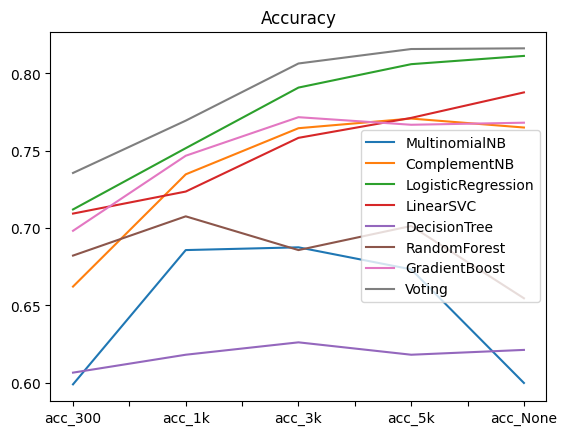

In [64]:
df_acc_T.plot()
plt.title("Accuracy")
plt.show()

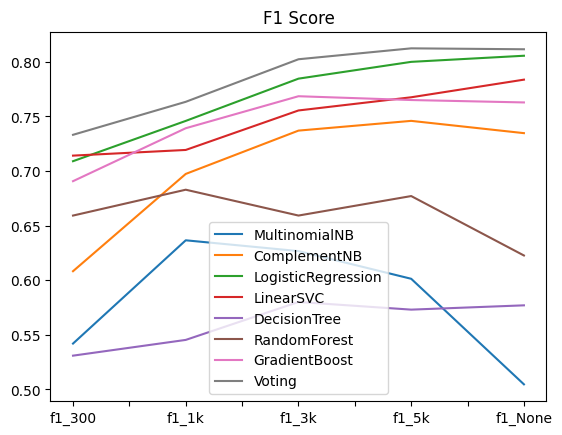

In [65]:
df_f1_T.plot()
plt.title("F1 Score")
plt.show()

#### 연산 시간 비교

In [82]:
# 단어 사전 크기
size = ["300", "1000", "3000", "5000", "unlimited"]

# 시간 (초)
time = [
    1453.4,
    1891.1,
    2107.8,
    2403.7,
    2461.3,
]

Text(0.5, 1.0, 'computing time (second)')

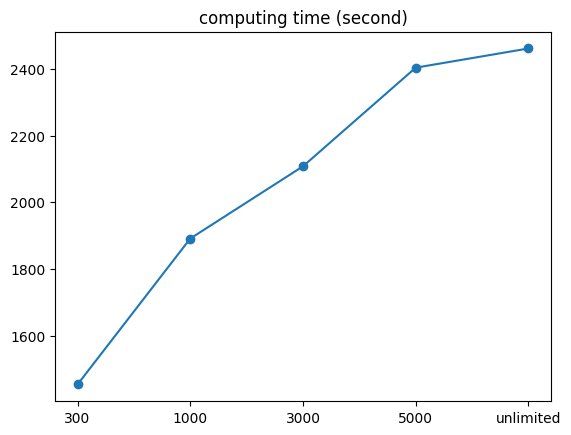

In [83]:
plt.plot(size, time, "-o")
plt.title("computing time (second)")

### 딥러닝 모델 성능 확인

일반적으로 성능이 제일 좋았던 단어사전 크기 5000개로 테스트  

감성분석에서 성능이 좋았던 BiLSTM으로 성능 테스트

accuracy: 0.7351  
f1 : 0.74      
> 하지만 희소 클래스는 예측을 잘 못하여 macro f1 avg는 0.29로 낮다


In [2]:
import tensorflow as tf

In [3]:
# 데이터 로드
def create_data(word_vocab_size):
    # 인코딩된 데이터를 복원
    def decoding(data):
        decoded = []
        for i in range(len(data)):
            t = " ".join([index_to_word[index] for index in data[i]])
            decoded.append(t)
        return decoded

    # 데이터 로드 및 분리
    (x_train, y_train), (x_test, y_test) = reuters.load_data(
        num_words=word_vocab_size, test_split=0.2
    )

    # 단어 -> 수치형 사전
    word_index = reuters.get_word_index(path="reuters_word_index.json")
    # 수치 -> 단어 사전
    index_to_word = {index + 3: word for word, index in word_index.items()}
    for index, token in enumerate(("<pad>", "<sos>", "<unk>")):  # 토큰 추가
        index_to_word[index] = token

    x_train = decoding(x_train)
    x_test = decoding(x_test)

    # TF-IDF변환을 위한 DTM
    dtmvector = CountVectorizer()
    x_train_dtm = dtmvector.fit_transform(x_train)

    # TF-IDF
    tfidf_transformer = TfidfTransformer()
    tfidfv = tfidf_transformer.fit_transform(x_train_dtm)

    # 테스트 데이터 tfidf 변환
    x_test_dtm = dtmvector.transform(x_test)
    tfidfv_test = tfidf_transformer.transform(x_test_dtm)

    return tfidfv, y_train, tfidfv_test, y_test

In [6]:
tfidfv, y_train, tfidfv_test, y_test = create_data(5000)

In [56]:
lstm_size = 128
model_lstm = tf.keras.Sequential()
# 희소행렬을 입력으로 받기위한 레이어
model_lstm.add(tf.keras.layers.Dense(units=lstm_size, input_shape=(tfidfv.shape[1],)))
model_lstm.add(tf.keras.layers.Reshape((1, lstm_size)))

# 양방향 lstm. dropout 0.2도 적용
model_lstm.add(
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(lstm_size, return_sequences=True, dropout=0.1)
    )
)
model_lstm.add(
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_size, dropout=0.1))
)

# 모델 복잡성을 위해 dense을 2층 쌓음
model_lstm.add(tf.keras.layers.Dense(lstm_size, activation="relu"))
model_lstm.add(tf.keras.layers.Dense(int(lstm_size / 2), activation="relu"))
model_lstm.add(tf.keras.layers.Dense(46, activation="softmax"))

model_lstm.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

In [57]:
EarlyStopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=3, min_delta=0.0001
)

history_lstm = model_lstm.fit(
    tfidfv,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(tfidfv_test, y_test),
    callbacks=[EarlyStopping],
)

Epoch 1/50


c:\Users\zzoon\anaconda3\envs\aiffel\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_9/dense_63/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_9/dense_63/embedding_lookup_sparse/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_9/dense_63/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


281/281 [==============================] - 10s 17ms/step - loss: 1.8570 - accuracy: 0.5110 - val_loss: 1.4526 - val_accuracy: 0.6140
Epoch 2/50
281/281 [==============================] - 4s 14ms/step - loss: 1.2701 - accuracy: 0.6454 - val_loss: 1.3633 - val_accuracy: 0.6394
Epoch 3/50
281/281 [==============================] - 5s 16ms/step - loss: 1.0428 - accuracy: 0.7191 - val_loss: 1.1943 - val_accuracy: 0.7021
Epoch 4/50
281/281 [==============================] - 4s 14ms/step - loss: 0.8229 - accuracy: 0.7867 - val_loss: 1.1933 - val_accuracy: 0.7008
Epoch 5/50
281/281 [==============================] - 4s 14ms/step - loss: 0.6779 - accuracy: 0.8193 - val_loss: 1.2024 - val_accuracy: 0.7195
Epoch 6/50
281/281 [==============================] - 4s 15ms/step - loss: 0.5609 - accuracy: 0.8496 - val_loss: 1.2292 - val_accuracy: 0.7262
Epoch 7/50
281/281 [==============================] - 4s 15ms/step - loss: 0.4856 - accuracy: 0.8657 - val_loss: 1.2652 - val_accuracy: 0.7351


In [58]:
pred = model_lstm.predict(tfidfv_test)

71/71 [==============================] - 2s 5ms/step


In [59]:
pred_classes = np.argmax(pred, axis=1)

In [60]:
print(classification_report(y_test, pred_classes, zero_division=0))

              precision    recall  f1-score   support

           0       0.41      0.58      0.48        12
           1       0.66      0.62      0.64       105
           2       0.65      0.55      0.59        20
           3       0.92      0.93      0.93       813
           4       0.83      0.86      0.85       474
           5       0.00      0.00      0.00         5
           6       0.50      0.57      0.53        14
           7       0.00      0.00      0.00         3
           8       0.43      0.74      0.54        38
           9       0.61      0.80      0.69        25
          10       0.63      0.73      0.68        30
          11       0.53      0.57      0.55        83
          12       0.00      0.00      0.00        13
          13       0.33      0.30      0.31        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.62      0.73      0.67        99
          17       0.00    

## 결론 및 회고

### 단어사전 크기에 따른 비교
단어사전 크기에 따른 성능의 추이를 보면 2가지로 분류할 수 있었다.  
1. 단어사전 크기가 클 수록 성능이 증가  
> ComplementNB, LogisticRegression, LinearSVC, DecisionTree, GradientBoost, Voting  

* 이 부류 역시 단어사전이 5000->무제한으로 바뀔 때 성능향상이 미미하거나 소폭 감소하였다.  


2. 단어 사전이 적정한 정도까지 성능이 오르다가 너무 많으면 성능이 떨어짐
> MultinomialNB, RandomForest

여기서 의외였던 건 RandomForest였는데, 성능자체는 DecisionTree보다 좋았지만, DecisionTree는 단어사전의 크기와 비례하여 성능이 향상되었지만, DecisionTree의 집합인 RandomForest는 다른 추이를 보였기 때문이다. 
> 영빈 퍼실님께서 우연의 결과일 것이라고 말씀하셨다.

한가지 또 눈여겨 봤던 건 연산시간이었는데, 단어사전 5000개와 무제한 즉 3만개일 때의 차이가 적었던 것이었다. 
> 이에 대해서는 영빈 퍼실님이 무제한의 경우 iteration을 다 돌지 않고 빨리 끝냈을 것이라고 하셨다.   


### 딥러닝 모델과의 비교
bilstm으로 테스트해봤는데, 성능이 좀 좋게 나왔던 모델들과 그닥 차이가 없었다.  
gpu가 되서인지는 모르겠지만, 연산시간도 부스팅이나 보팅보다 훨씬 빨랐다.  


### 회고
무제한 단어 사전의 경우 iteration이 일찍 종료되었을 것이라고 추정되는데, 일반적으로 단어 사전이 클수록 iteration 종료가 빠른건지 테스트를 해보고 싶었지만, 시간이 없어서 하지 못하였다.  
딥러닝 모델은 하나를 그냥 테스트한 것 뿐이지만, 그래도 머신러닝보다 좋을 것이라는 생각이 있었는데, 비슷비슷하여서 좀 충격이었다. 처음에 dlthon에서 사용했던 셀프어텐션 인코더를 사용하려고 하였는데, 생각해보니 이게 nlp라도 입력데이터가 tf-idf화 되어있는 것이어서 적용을 못하였다. 비슷하게 rnn 계열 역시 데이터를 시퀀스적으로 볼텐데 tf-idf 테이블을 학습하고도 이정도 성능이 나온것에 신기해야 할 수도 있다고 생각하였다. 